### Denoising the keras mnist dataset using autoencoders. 

In [2]:
# Importing libraries and initializing them. 

# Math 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Network
import tensorflow as tf

from tensorflow.keras.callbacks import LambdaCallback, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Conv2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical


#### Inititzialize mnist dataset

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

print("Shape training set: {}".format(x_train.shape))
print("Shape test set: {}".format(x_test.shape))

Shape training set: (60000, 28, 28)
Shape test set: (10000, 28, 28)


#### Normalize the train and test dataset.

In [4]:
# Training data
x_train = x_train.astype('float32') / 255.

x_train = np.reshape(x_train, (len( x_train ), 28, 28, 1))
print("Normalized train set: {}".format(x_train.shape))


Normalized train set: (60000, 28, 28, 1)


In [5]:
# Test data
x_test = x_test.astype('float32') / 255.

x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print("Shape test set: {}".format(x_test.shape))

Shape test set: (10000, 28, 28, 1)


#### Generate noise.
To develop a generalized model, a bit of noise is added to the data to make it corrupt. The data that is not corrupted is kept and used as the output. Because the model can't remember the training data, it uses the output as input. Different output goals are set.



In [6]:
noisy_x_train = x_train + 0.5 * np.random.normal(size=x_train.shape) 
noisy_x_test = x_test + 0.5 * np.random.normal(size=x_test.shape) 

noisy_x_train = np.clip(noisy_x_train, 0., 1.)
noisy_x_test = np.clip(noisy_x_test, 0., 1.)

print("Shape test set: {}".format(noisy_x_test.shape))


Shape test set: (10000, 28, 28, 1)


#### Create the encoder. 
We are going to use Functional API to build our convolutional autoencoder.

In [7]:
# building the encoder network to map the input into the code. 
image = Input(shape=(28,28,1))

x = Conv2D(32,(3,3),activation='relu', padding='same')(image)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(32,(3,3),activation='relu', padding='same')(x)
encoded_image = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(image, encoded_image)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


2022-05-09 14:34:45.806363: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-09 14:34:45.806915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 14:34:45.818520: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Create the decoder network

In [8]:
# building the convolutional decoder network to map the code into a reconstruction of the input. 

decoder_input_code = Input(shape=(7,7,32))

x = Conv2D(32,(3,3),activation='relu',padding='same')(decoder_input_code)
x = UpSampling2D((2,2))(x)
x = Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)

decoded_image = Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

decoder = Model(decoder_input_code, decoded_image)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 32)]        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 18,785
Trainable params: 18,785
Non-trainable params: 0
_______________________________________________________

In [9]:
# create the autoencoder by tying the encode and decode networks together
autoencoder_input = Input(shape=(28,28,1))

encoded_image = encoder(autoencoder_input)
decoded_image = decoder(encoded_image)

autoencoder = Model(autoencoder_input, decoded_image)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 7, 7, 32)          9568      
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         18785     
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


Train the autoencoder on the noisy images, with their clean counterparts.

In [11]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

autoencoder.fit(noisy_x_train, x_train,epochs=5,batch_size=128, shuffle = True)


2022-05-09 14:35:06.843308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-09 14:35:06.845895: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1094400000 Hz


Epoch 1/5
469/469 [==============================] - 260s 546ms/step - loss: 0.2362
Epoch 2/5
469/469 [==============================] - 271s 578ms/step - loss: 0.1144
Epoch 3/5
469/469 [==============================] - 279s 596ms/step - loss: 0.1076
Epoch 4/5
469/469 [==============================] - 310s 660ms/step - loss: 0.1047
Epoch 5/5
469/469 [==============================] - 293s 625ms/step - loss: 0.1023


Encode the first few images from the set using the encoder. 

In [14]:
encoded_images = encoder.predict(noisy_x_test[:10])
print(encoded_images.shape)

(10, 7, 7, 32)


Cycle the encoded noisy images through the decoder.

In [15]:
decoded_images = decoder.predict(encoded_images)
print(decoded_images.shape)

(10, 28, 28, 1)


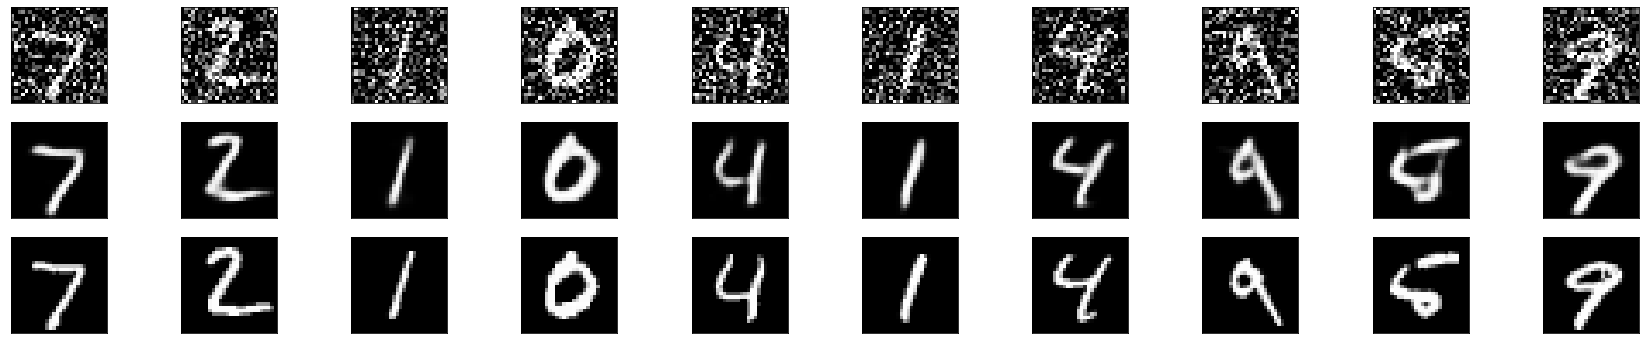

In [16]:
# display the images

plt.figure(figsize=(30,6))
for i in range(10):

  # plotting the noisy images
  ax = plt.subplot(3,10,i+1)
  plt.imshow(noisy_x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # plotting the denoised images
  ax = plt.subplot(3,10,i+1+10)
  plt.imshow(decoded_images[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # plotting the original images
  ax = plt.subplot(3,10,i+1+10*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
    
plt.show()